In [1]:
import numpy as np
import torch
import os
import sys
from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import pandas as pd
%matplotlib inline

In [2]:
sys.path.append('../')
from segmentation.unet.architectures.unet_model import MultiUNet
from segmentation.unet.model.model import Model

In [7]:
weights_path = '../data/weights/segmentation/multiunet/model-120.trh'
unet = Model(MultiUNet(1, 4), 'cuda')
unet.load(weights_path)

In [8]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def mask2enc(mask, n=1):
    pixels = mask.T.flatten()
    encs = []
    for i in range(1,n+1):
        p = (pixels == i).astype(np.int8)
        if p.sum() == 0: encs.append('')
        else:
            p = np.concatenate([[0], p, [0]])
            runs = np.where(p[1:] != p[:-1])[0] + 1
            runs[1::2] -= runs[::2]
            encs.append(' '.join(str(x) for x in runs))
    return encs

In [9]:
path_to_dataset = '../data/dataset/'
train_images_folder = os.path.join(path_to_dataset, 'test_images')

In [19]:
images_pathes_list = [os.path.join(train_images_folder, imn) for imn in os.listdir(train_images_folder)]
len(images_pathes_list)

1801

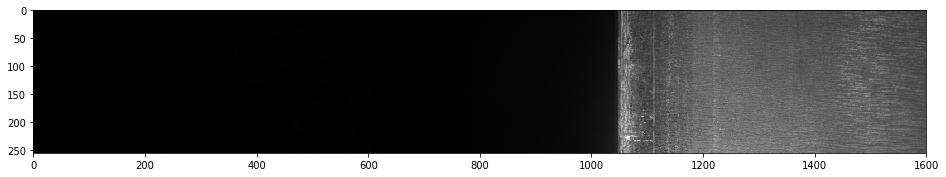

In [27]:
img_id = 1000
img = np.array(Image.open(images_pathes_list[img_id]).convert('LA'))[..., 0]

plt.figure(figsize=(16, 10))
plt.imshow(img, 'gray')
plt.show()

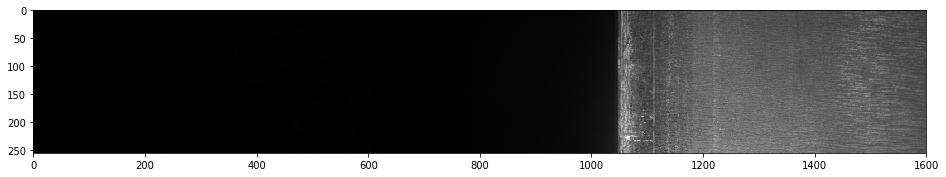

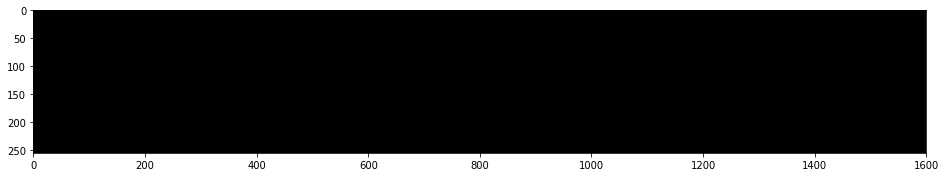

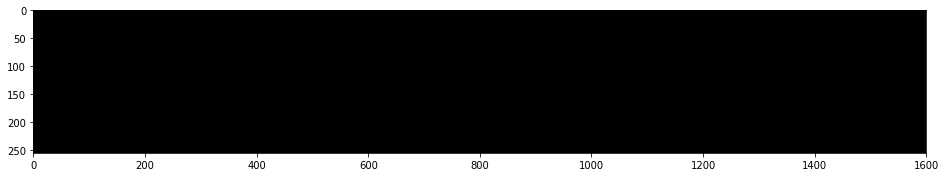

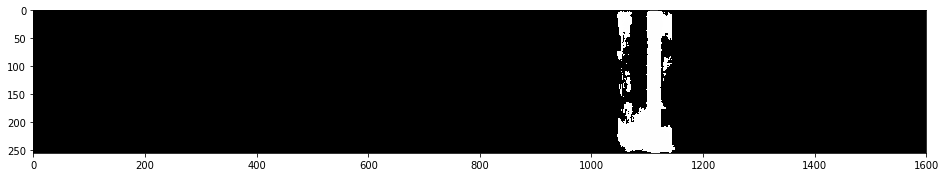

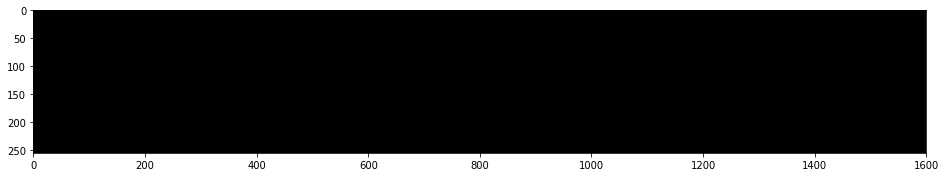

In [32]:
plt.figure(figsize=(16, 10))
plt.imshow(img, 'gray')
plt.show()

for ch in unet.predict(
    torch.FloatTensor(img.astype(np.float32) / 255).unsqueeze(0).unsqueeze(0).to('cuda'), 0.1
)[0]:
    channel = (ch.detach().to('cpu').numpy() * 255).astype(np.uint8)
    
    plt.figure(figsize=(16, 10))
    plt.imshow(channel, 'gray')
    plt.show()

In [50]:
results = []

for img_path in tqdm(images_pathes_list[:5]):
    img = np.array(Image.open(img_path).convert('LA'))[..., 0]
    
    img_name = os.path.basename(img_path)
    
    for i, ch in enumerate(unet.predict(
        torch.FloatTensor(img.astype(np.float32) / 255).unsqueeze(0).unsqueeze(0).to('cuda'), 0.02
    )[0]):
        channel = (ch.detach().to('cpu').numpy()).astype(np.uint8)
        rle = mask2enc(channel)
        
        results.append(
            [
                '{img_name}_{ch_id}'.format(
                    img_name=img_name,
                    ch_id=i + 1,
                    rle = rle
                ), rle
            ]
        )
        
df = pd.DataFrame(results, columns=['ImageId_ClassId', 'EncodedPixels'])
df.to_csv("../data/submission.csv", index=False)